In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import sqrt, atan, degrees

#Functions

In [ ]:
def detect_lines_ransac(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100,
                            minLineLength=100, maxLineGap=10)

    line_image = np.zeros_like(image)

    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 3)

    return line_image

def find_longest_line(plate_img_gr):
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(plate_img_gr, (kernel_size, kernel_size), 0)

    low_threshold = 150
    high_threshold = 200

    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50  # minimum number of pixels making up a line
    max_line_gap = 5  # maximum gap in pixels between connectable line segments
    line_image = np.copy(plate_img) * 0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

    lls = []
    for indx, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
            line_length = sqrt((x2-x1)**2 + (y2-y1)**2)
            lls.append((indx,line_length))
    lls.sort(key = lambda x: x[1])
    linessorted = []
    for (indx,ll) in lls:
        linessorted.append(lines[indx])

    # Draw the lines on the  image
    lines_edges = cv2.addWeighted(plate_img, 0.8, line_image, 1, 0)
    return linessorted ,lines_edges

def find_line_angle(line):
    x1,y1,x2,y2 = line[0]
    angle = degrees(atan(((y2-y1)/(x2-x1))))
    return angle

def rotate_image(plate_img_gr, angle):
    (h, w) = plate_img_gr.shape
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(plate_img_gr, M, (w, h))
    return rotated

def adjust_cropping(rotated_img):
    h,w = rotated_img.shape
    targ_h = int(w/4)
    crop_h = int((h - targ_h)/2)
    print(h)
    if crop_h >= 0:
        cropped_rotated_img = rotated_img[crop_h:h - crop_h, :]
    else:
        cropped_rotated_img = rotated_img

    return cropped_rotated_img

# def crop_license_plate(image):
#     gray = image
#     blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#     edges = cv2.Canny(blurred, 50, 150)

#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if len(contours) == 0:
#         return None

#     contour = max(contours, key=cv2.contourArea)
#     x, y, w, h = cv2.boundingRect(contour)

#     cropped_image = image[y:y+h, x:x+w]
#     return cropped_image

def crop_license_plate(image):
    gray = image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    cropped_image = image[y:y+h, x:x+w]
    return cropped_image


In [ ]:
import matplotlib.pyplot as plt

def display_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Main

In [ ]:
class_names = subdirs =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'ch', 'd', 'ein', 'f', 'g', 'ghaf', 'ghein', 'h2', 'hj', 'j', 'k', 'kh', 'l', 'm', 'n', 'p', 'r', 's', 'sad', 'sh', 't', 'ta', 'th', 'v', 'y', 'z', 'za', 'zad', 'zal', 'zh']
labels_nums = [i for i in range(0,len(class_names))]


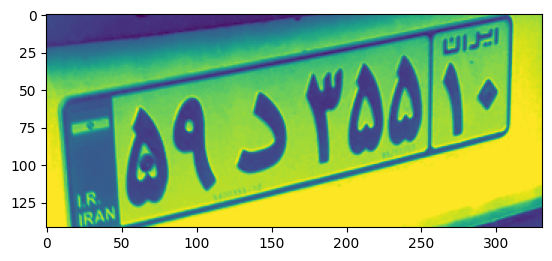

In [ ]:
# plates_folder = "/content/gdrive/MyDrive/DL_projects_colab/plate_imgs"
# plate_img = cv.imread(os.path.join(plates_folder, "plate_4.jpg"))
# plate_img_gr = cv.imread(os.path.join(plates_folder, "plate_4.jpg"), 0 )
plate_img = cv2.imread('/content/gdrive/MyDrive/Ocr/p1.png')
plate_img_gr = cv2.imread('/content/gdrive/MyDrive/Ocr/p1.png', 0 )
plt.imshow(plate_img_gr)

In [ ]:
linessorted = find_longest_line(plate_img_gr)[0]
img_with_lines_edges = find_longest_line(plate_img_gr)[1]
# lines_edges2 =detect_lines_ransac(plate_img)
rot_angle = find_line_angle(linessorted[-1])
rotated_img = rotate_image(plate_img_gr, rot_angle)
# cropped_rotated_img = adjust_cropping(rotated_img)
cropped_rotated_img = crop_license_plate(rotated_img)
cw = cropped_rotated_img.shape[1]

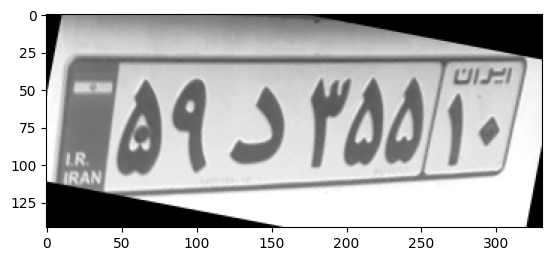

In [ ]:
plt.imshow(rotated_img ,cmap='gray')

In [ ]:
rot_angle

-10.844810902108737

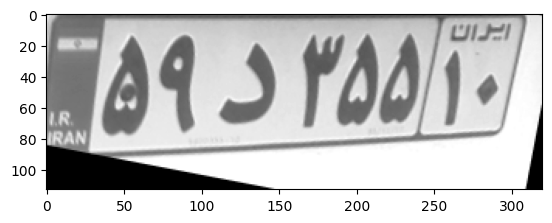

In [ ]:
plt.imshow(cropped_rotated_img,cmap='gray')


In [ ]:
h, w = cropped_rotated_img.shape
chopfactors = [(40,120),(100,200),(180,280),(270,360),(350,400),(400,460),(460,530),(530,600)]

In [ ]:
plate_letters= []
for factor in chopfactors:
    w1 = int((factor[0]/600)*w)
    w2 = int((factor[1]/600)*w)
    letterpatch = cropped_rotated_img[:,w1:w2]
    #cv.imwrite(f"{str(factor[0])}_{str(factor[1])}.png", letterpatch)
    letterpatch_resized = cv2.resize(letterpatch, (28,28), interpolation= cv2.INTER_LINEAR)
    plate_letters.append(letterpatch_resized)

plate_letters = np.array(plate_letters)
plate_letters.shape

(8, 28, 28)

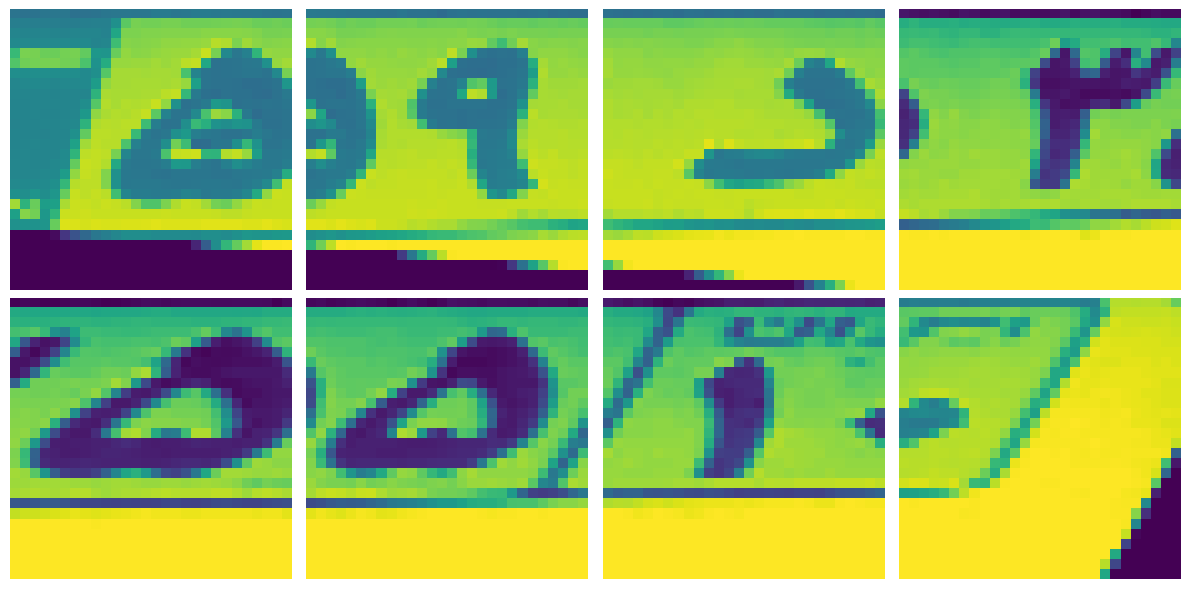

In [ ]:
display_images(plate_letters)

In [ ]:
ocr_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Ocr/saved_model/simple_ocr_plates_model')

In [ ]:
predictions = ocr_model.predict(plate_letters)

1/1 [==============================] - 0s 29ms/step


In [ ]:
predictions

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        9.9999994e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 9.9999994e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0

In [ ]:
[class_names[k] for k in list(np.argmax(predictions, axis=1))]

['8', '5', 'ch', '4', '3', '1', '1', '3']